# HT2 - DL

## Autores

- Angel Higueros
- Fredy Velasquez

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Task 1

In [3]:
# Task 1 - Preparación del conjunto de datos
iris = load_iris()
X = iris.data
y = iris.target

# Escalar y dividir los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convertir a tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_val = torch.tensor(y_val, dtype=torch.int64)

## Task 2 

In [4]:
# Task 2 - Arquitectura modelo
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Task 3, 4, 5

In [5]:
def train_model(loss_function, regularization=None, optimizer_type='SGD'):
    model = SimpleNN(4, 50, 3)
    if regularization == 'L1':
        criterion = loss_function(reduction='mean')
        optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=0.01, weight_decay=0.01)
    elif regularization == 'L2':
        criterion = loss_function(reduction='mean')
        optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=0.01, weight_decay=0.1)
    elif regularization == 'dropout':
        model = nn.Sequential(
            model,
            nn.Dropout(0.5)
        )
        criterion = loss_function(reduction='mean')
        optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=0.01)
    else:
        criterion = loss_function(reduction='mean')
        optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=0.01)
    
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
    return model

## Task 6

Training model with Loss-CrossEntropyLoss_Reg-none_Opt-SGD
Training model with Loss-CrossEntropyLoss_Reg-none_Opt-Adam
Training model with Loss-CrossEntropyLoss_Reg-none_Opt-RMSprop
Training model with Loss-CrossEntropyLoss_Reg-L1_Opt-SGD
Training model with Loss-CrossEntropyLoss_Reg-L1_Opt-Adam
Training model with Loss-CrossEntropyLoss_Reg-L1_Opt-RMSprop
Training model with Loss-CrossEntropyLoss_Reg-L2_Opt-SGD
Training model with Loss-CrossEntropyLoss_Reg-L2_Opt-Adam
Training model with Loss-CrossEntropyLoss_Reg-L2_Opt-RMSprop
Training model with Loss-CrossEntropyLoss_Reg-dropout_Opt-SGD
Training model with Loss-CrossEntropyLoss_Reg-dropout_Opt-Adam
Training model with Loss-CrossEntropyLoss_Reg-dropout_Opt-RMSprop


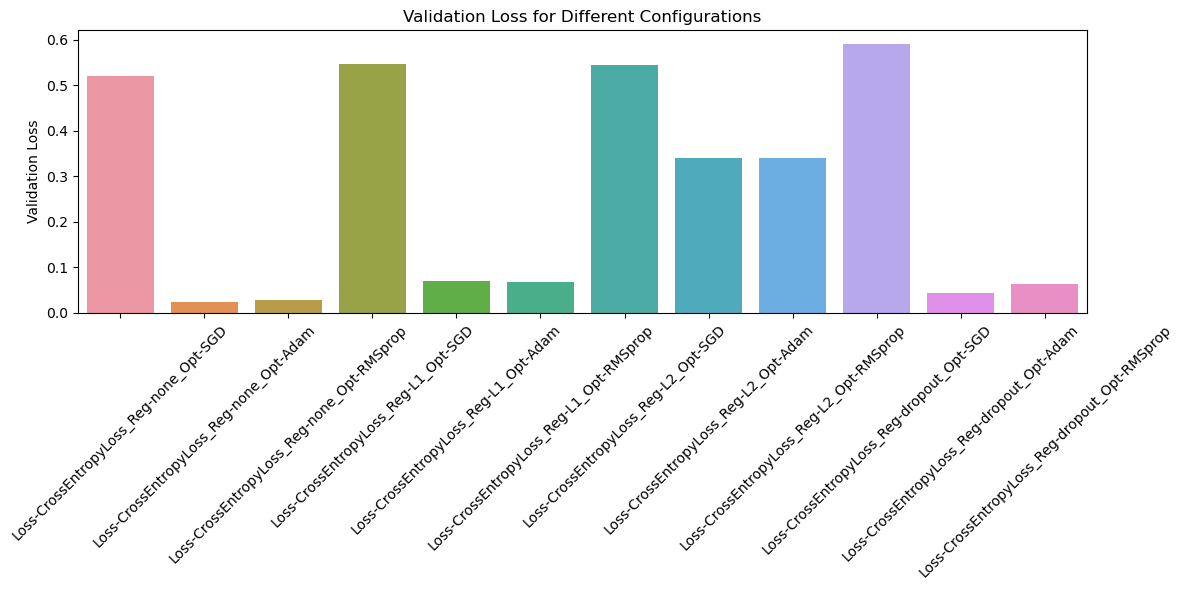

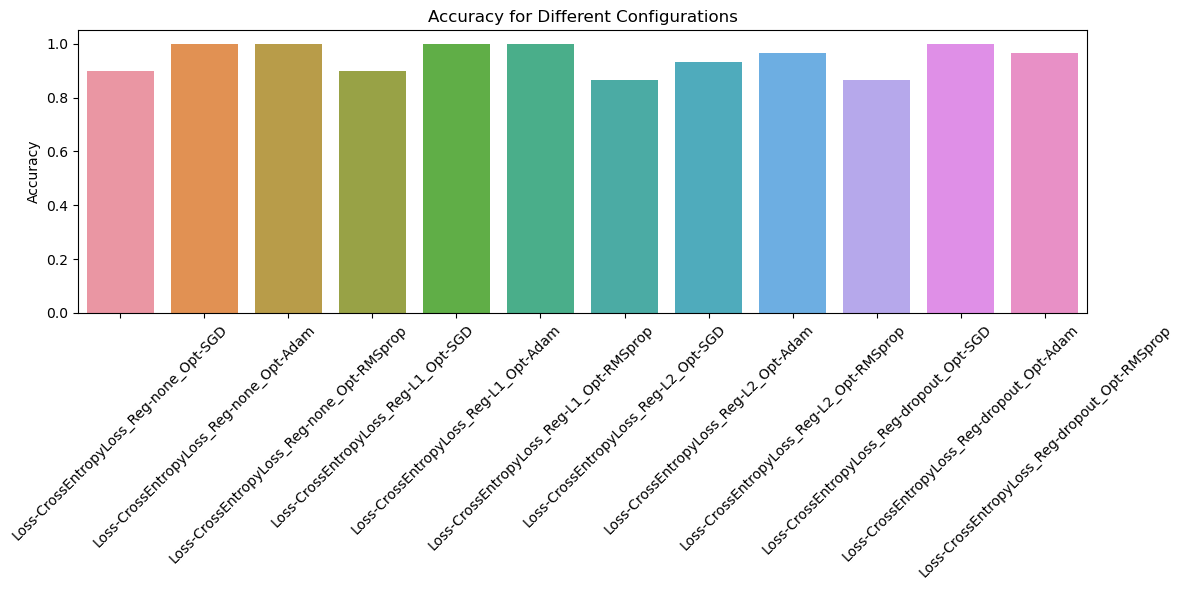

In [6]:
loss_functions = [nn.CrossEntropyLoss]
regularizations = [None, 'L1', 'L2', 'dropout']
optimizers = ['SGD', 'Adam', 'RMSprop']

metrics = {}
for loss_fn in loss_functions:
    for reg in regularizations:
        for opt in optimizers:
            key = f"Loss-{loss_fn.__name__}_Reg-{reg if reg else 'none'}_Opt-{opt}"
            print(f"Training model with {key}")
            model = train_model(loss_fn, reg, opt)
            
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = loss_fn()(val_outputs, y_val)
                _, preds = torch.max(val_outputs, 1)
                accuracy = torch.sum(preds == y_val).item() / len(y_val)
                metrics[key] = {'Validation Loss': val_loss.item(), 'Accuracy': accuracy}

# Visualización
df = pd.DataFrame(metrics).T

plt.figure(figsize=(12,6))
sns.barplot(x=df.index, y=df['Validation Loss'])
plt.title('Validation Loss for Different Configurations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x=df.index, y=df['Accuracy'])
plt.title('Accuracy for Different Configurations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()